#  1 - Keras 入门 - 笑脸识别

本次我们将：

学习到一个高级的神经网络的框架，能够运行在包括TensorFlow和CNTK的几个较低级别的框架之上的框架。
看看如何在几个小时内建立一个深入的学习算法。
  为什么我们要使用Keras框架呢？Keras是为了使深度学习工程师能够很快地建立和实验不同的模型的框架，正如TensorFlow是一个比Python更高级的框架，Keras是一个更高层次的框架，并提供了额外的抽象方法。最关键的是Keras能够以最短的时间让想法变为现实。然而，Keras比底层框架更具有限制性，所以有一些非常复杂的模型可以在TensorFlow中实现，但在Keras中却没有（没有更多困难）。 话虽如此，Keras对许多常见模型都能正常运行。



In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
import kt_utils 

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline


### 1.1 - 任务描述
  下一次放假的时候，你决定和你的五个朋友一起度过一个星期。这是一个非常好的房子，在附近有很多事情要做，但最重要的好处是每个人在家里都会感到快乐，所以任何想进入房子的人都必须证明他们目前的幸福状态。

  作为一个深度学习的专家，为了确保“快乐才开门”规则得到严格的应用，你将建立一个算法，它使用来自前门摄像头的图片来检查这个人是否快乐，只有在人高兴的时候，门才会打开。
  
  <img src="images/happy-house.jpg" style="width:350px;height:270px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **the Happy House**</center></caption>
    
你收集了你的朋友和你自己的照片，被前门的摄像头拍了下来。数据集已经标记好了。
    <img src="images/house-members.png" style="width:550px;height:250px;">

我们先来加载数据集：

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = kt_utils.load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


### 1.2 - 使用Keras框架构建模型
Keras非常适合快速制作模型，它可以在很短的时间内建立一个很优秀的模型，举个例子：

In [3]:
def model(input_shape):    
    #定义一个tensor的placeholder，维度为input_shape
    X_input = Input(input_shape)
    
    #使用0填充：X_input的周围填充0
    X = ZeroPadding2D((3,3))(X_input)
    
    # 对X使用 CONV -> BN -> RELU 块
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    #最大值池化层
    X = MaxPooling2D((2,2),name="max_pool")(X)
    
    #降维，矩阵转化为向量 + 全连接层
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    #创建模型，讲话创建一个模型的实体，我们可以用它来训练、测试。
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
    


  **请注意**：Keras框架使用的变量名和我们以前使用的numpy和TensorFlow变量不一样。它不是在前向传播的每一步上创建新变量（比如X, Z1, A1, Z2, A2,…）以便于不同层之间的计算。在Keras中，我们使用X覆盖了所有的值，没有保存每一层结果，我们只需要最新的值，唯一例外的就是X_input，我们将它分离出来是因为它是输入的数据，我们要在最后的创建模型那一步中用到。附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/u013733326/article/details/80250818

In [4]:
def HappyModel(input_shape):
    """
    实现一个检测笑容的模型
    
    参数：
        input_shape - 输入的数据的维度
    返回：
        model - 创建的Keras的模型
        
    """
    
    #你可以参考和上面的大纲
    X_input = Input(input_shape)

    #使用0填充：X_input的周围填充0
    X = ZeroPadding2D((3, 3))(X_input)

    #对X使用 CONV -> BN -> RELU 块
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    #最大值池化层
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    #降维，矩阵转化为向量 + 全连接层
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    #创建模型，讲话创建一个模型的实体，我们可以用它来训练、测试。
    model = Model(inputs=X_input, outputs=X, name='HappyModel')

    return model


现在我们已经设计好了我们的模型了，要训练并测试模型我们需要这么做：

1. 创建一个模型实体。   
2. 编译模型，可以使用这个语句：model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])。  
3. 训练模型：model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)。  
4. 评估模型：model.evaluate(x = ..., y = ...)。  

如果你想要获取关于model.compile(), model.fit(), model.evaluate()的更多的信息，你可以参考这里。  

In [5]:
#创建一个模型实体
happy_model = HappyModel(X_train.shape[1:])
#编译模型
happy_model.compile("adam","binary_crossentropy", metrics=['accuracy'])
#训练模型
#请注意，此操作会花费你大约6-10分钟。
happy_model.fit(X_train, Y_train, epochs=40, batch_size=50)
#评估模型
preds = happy_model.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print ("误差值 = " + str(preds[0]))
print ("准确度 = " + str(preds[1]))


2023-02-23 23:12:19.641754: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 23:12:21.177532: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
12/12 [==============================] - 6s 341ms/step - loss: 1.3433 - accuracy: 0.6233
Epoch 2/40
12/12 [==============================] - 3s 229ms/step - loss: 0.3595 - accuracy: 0.8617
Epoch 3/40
12/12 [==============================] - 3s 236ms/step - loss: 0.2637 - accuracy: 0.9117
Epoch 4/40
12/12 [==============================] - 3s 236ms/step - loss: 0.1590 - accuracy: 0.9400
Epoch 5/40
12/12 [==============================] - 3s 205ms/step - loss: 0.1197 - accuracy: 0.9667
Epoch 6/40
12/12 [==============================] - 2s 198ms/step - loss: 0.0919 - accuracy: 0.9750
Epoch 7/40
12/12 [==============================] - 2s 197ms/step - loss: 0.0811 - accuracy: 0.9783
Epoch 8/40
12/12 [==============================] - 3s 214ms/step - loss: 0.0897 - accuracy: 0.9650
Epoch 9/40
12/12 [==============================] - 3s 217ms/step - loss: 0.0704 - accuracy: 0.9767
Epoch 10/40
12/12 [==============================] - 3s 219ms/step - loss: 0.0686 - accuracy: 0.9817

### 1.3 - 测试你的图片
因为对这些数据进行训练的模型可能或不能处理你自己的图片，但是你可以试一试嘛：

[[1.]]


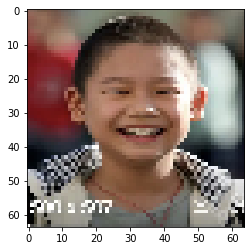

In [12]:

img_path = 'images/smile.jpg'

img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happy_model.predict(x))


In [14]:
happy_model.summary()


Model: "HappyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

In [40]:
%matplotlib inline
plot_model(happy_model, to_file='happy_model.png')
SVG(model_to_dot(happy_model).create(prog='dot', format='svg'))

# 这里要安装相应插件，我没安

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


AttributeError: 'NoneType' object has no attribute 'create'

# 2 - 残差网络的搭建

这里我们将学习怎样使用残差网络构建一个非常深的卷积网络。理论上越深的网络越能够实现越复杂的功能，但是在实际上却非常难以训练。**残差网络**就是为了解决深网络的难以训练的问题的。

在本文章中，我们将：

实现基本的残差块。
将这些残差块放在一起，实现并训练用于图像分类的神经网络。
本次实验将使用**Keras框架**

在解决问题之前，我们先来导入库函数：

In [15]:
import numpy as np
import tensorflow as tf

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform

import pydot
from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import resnets_utils 


/Users/chenchangming/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## 2.1 - 深层网络的问题
  上周，我们构建了第一个卷积神经网络。最近几年，卷积神经网络变得越来越深，从只从几层（例如AlexNet）到超过一百层。

  使用深层网络最大的好处就是它能够完成很复杂的功能，它能够从边缘（浅层）到非常复杂的特征（深层）中不同的抽象层次的特征中学习。然而，使用比较深的网络通常没有什么好处，一个特别大的麻烦就在于训练的时候会产生梯度消失，非常深的网络通常会有一个梯度信号，该信号会迅速的消退，从而使得梯度下降变得非常缓慢。更具体的说，在梯度下降的过程中，当你从最后一层回到第一层的时候，你在每个步骤上乘以权重矩阵，因此梯度值可以迅速的指数式地减少到0（在极少数的情况下会迅速增长，造成梯度爆炸）。

  在训练的过程中，你可能会看到开始几层的梯度的大小（或范数）迅速下降到0，如下图：
  <img src="images/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> **图 1** </u><font color='purple'>  : **梯度消失** <br> 在前几层中随着迭代次数的增加，学习的速度会下降的非常快 </center></caption>
    
  为了解决这个问题，我们将构建残差网络。

## 2.2 - 构建一个残差网络
  在残差网络中，一个“捷径（shortcut）”或者说“跳跃连接（skip connection）”允许梯度直接反向传播到更浅的层，如下图：
  <img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> **图 2** </u><font color='purple'>  : 残差网络中跳跃连接的残差块示意 <br> </center></caption>


 图像左边是神经网络的主路，图像右边是添加了一条捷径的主路，通过这些残差块堆叠在一起，可以形成一个非常深的网络。

  我们在视频中可以看到使用捷径的方式使得每一个残差块能够很容易学习到恒等式功能，这意味着我们可以添加很多的残差块而不会损害训练集的表现。

  残差块有两种类型，主要取决于输入输出的维度是否相同，下面我们来看看吧~

### 2.2.1 - 恒等块（Identity block）

  恒等块是残差网络使用的的标准块，对应于输入的激活值（比如$a^{[l]}$）与输出激活值（比如$a^{[l+2]}$ ）具有相同的维度。为了具象化残差块的不同步骤，我们来看看下面的图吧~

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **图 3** </u><font color='purple'>  : **恒等块** 使用的是跳跃连接，幅度为两层。 </center></caption>

 上图中，上面的曲线路径是“捷径”，下面的直线路径是主路径。在上图中，我们依旧把CONV2D 与 ReLU包含到了每个步骤中，为了提升训练的速度，我们在每一步也把数据进行了归一化（BatchNorm），不要害怕这些东西，因为Keras框架已经实现了这些东西，调用BatchNorm只需要一行代码。

  在实践中，我们要做一个更强大的版本：跳跃连接会跳过3个隐藏层而不是两个，就像下图：

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **图 4** </u><font color='purple'>  : **恒等块。** 使用的是跳跃连接，幅度为三层。</center></caption>

    

In [16]:
def identity_block(X, f, filters, stage, block):
    """
    实现图3的恒等块
    
    参数：
        X - 输入的tensor类型的数据，维度为( m, n_H_prev, n_W_prev, n_H_prev )
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        
    返回：
        X - 恒等块的输出，tensor类型，维度为(n_H, n_W, n_C)
    
    """
    
    #定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"
    
    #获取过滤器
    F1, F2, F3 = filters
    
    #保存输入数据，将会用于为主路径添加捷径
    X_shortcut = X
    
    #主路径的第一部分
    ##卷积层
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1) ,padding="valid",
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    #主路径的第二部分
    ##卷积层
    X = Conv2D(filters=F2, kernel_size=(f,f),strides=(1,1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    
    #主路径的第三部分
    ##卷积层
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)
    ##没有ReLU激活函数
    
    #最后一步：
    ##将捷径与输入加在一起
    X = Add()([X,X_shortcut])
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    return X


In [17]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [18]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    np.random.seed(1)
    A_prev = tf.compat.v1.placeholder("float",[3,4,4,6])
    X = np.random.randn(3,4,4,6)
    A = identity_block(A_prev,f=2,filters=[2,4,6],stage=1,block="a")
    
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A],feed_dict={A_prev:X,K.learning_phase():0})
    print("out = " + str(out[0][1][1][0]))
    
    test.close()


Instructions for updating:
Colocations handled automatically by placer.
out = [0.        0.        1.3454674 2.031818  0.        1.3246754]


In [19]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    实现图5的卷积块
    
    参数：
        X - 输入的tensor类型的变量，维度为( m, n_H_prev, n_W_prev, n_C_prev)
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        s - 整数，指定要使用的步幅
    
    返回：
        X - 卷积块的输出，tensor类型，维度为(n_H, n_W, n_C)
    """
    
    #定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"
    
    #获取过滤器数量
    F1, F2, F3 = filters
    
    #保存输入数据
    X_shortcut = X
    
    #主路径
    ##主路径第一部分
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    X = Activation("relu")(X)
    
    ##主路径第二部分
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)
    
    ##主路径第三部分
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)
    
    #捷径
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"1", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name=bn_name_base+"1")(X_shortcut)
    
    #最后一步
    X = Add()([X,X_shortcut])
    X = Activation("relu")(X)
    
    return X


In [20]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as test:
    np.random.seed(1)
    A_prev = tf.compat.v1.placeholder("float",[3,4,4,6])
    X = np.random.randn(3,4,4,6)
    
    A = convolutional_block(A_prev,f=2,filters=[2,4,6],stage=1,block="a")
    test.run(tf.compat.v1.global_variables_initializer())
    
    out = test.run([A],feed_dict={A_prev:X,K.learning_phase():0})
    print("out = " + str(out[0][1][1][0]))
    
    test.close()


out = [0.         0.         0.         0.8929657  0.         0.19882731]


In [21]:
def ResNet50(input_shape=(64,64,3),classes=6):
    """
    实现ResNet50
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    
    参数：
        input_shape - 图像数据集的维度
        classes - 整数，分类数
        
    返回：
        model - Keras框架的模型
        
    """
    
    #定义tensor类型的输入数据
    X_input = Input(input_shape)
    
    #0填充
    X = ZeroPadding2D((3,3))(X_input)
    
    #stage1
    X = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), name="conv1",
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size=(3,3), strides=(2,2))(X)
    
    #stage2
    X = convolutional_block(X, f=3, filters=[64,64,256], stage=2, block="a", s=1)
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="b")
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="c")
    
    #stage3
    X = convolutional_block(X, f=3, filters=[128,128,512], stage=3, block="a", s=2)
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="b")
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="c")
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="d")
    
    #stage4
    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block="a", s=2)
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="b")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="c")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="d")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="e")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="f")
    
    #stage5
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block="a", s=2)
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="b")
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="c")
    
    #均值池化层
    X = AveragePooling2D(pool_size=(2,2),padding="same")(X)
    
    #输出层
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", name="fc"+str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)
    
    
    #创建模型
    model = Model(inputs=X_input, outputs=X, name="ResNet50")
    
    return model


In [22]:
model = ResNet50(input_shape=(64,64,3),classes=6)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])



In [43]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = resnets_utils.load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = resnets_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = resnets_utils.convert_to_one_hot(Y_test_orig, 6).T

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))


number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [24]:
model.fit(X_train,Y_train,epochs=2,batch_size=32)


Train on 1080 samples
Epoch 1/2
1080/1080 [==============================] - 71s 66ms/sample - loss: 2.4937 - acc: 0.4694
Epoch 2/2
1080/1080 [==============================] - 67s 62ms/sample - loss: 0.8747 - acc: 0.7324


In [25]:
preds = model.evaluate(X_test,Y_test)

print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))



/Users/chenchangming/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


误差值 = 4.224642690022787
准确率 = 0.16666667


In [38]:
#加载模型
model = load_model("ResNet50.h5") 


In [39]:
preds = model.evaluate(X_test,Y_test)
print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))

/Users/chenchangming/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


误差值 = 0.10854303936163584
准确率 = 0.96666664


my_image.shape = (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[1. 0. 0. 0. 0. 0.]]


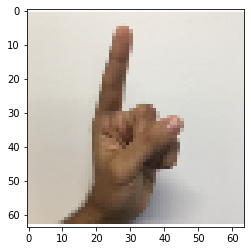

In [56]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt # plt 用于显示图片

%matplotlib inline

img_path = 'images/test1.jpg'

my_image = image.load_img(img_path, target_size=(64, 64))
my_image = image.img_to_array(my_image)

my_image = np.expand_dims(my_image,axis=0)
my_image = preprocess_input(my_image)

print("my_image.shape = " + str(my_image.shape))

print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(my_image))

my_image = image.load_img(img_path, target_size=(64, 64))
imshow(my_image)


In [81]:
model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [82]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))
# 跟上面一样的情况  我没安装画图所需的库

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


AttributeError: 'NoneType' object has no attribute 'create'